From Bob:

I have no idea what is going on here:  We are sky noise limited in 5min.  So in an hour we can probably be sky noise limited with a filter that has a width of about 150 / 12 "nm"  

In [1]:
150./12.

12.5

H$\alpha$ is at 656.3nm, the Coma cluster is at 8000 km/s (call it 10,000 km/s allowing for 2x the RMS velocity dispersion of a huge cluster), and Virgo is at about 2000 km/s, Leo I has redshift of 750 km/s.   

v = H_0 d | d = 20 Mpc | H_0 = 70 km/s/Mpc  --> v = 1400 km/s


In [225]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from matplotlib.patches import Ellipse

In [3]:
halpha_rest = 656.3 *u.nm # nm
c = 300000.               # km/s
def halpha_z(v):
    return halpha_rest*(1+(v/c))

In [4]:
print('redshift of Coma:  '+str(halpha_z(10000)-halpha_rest))
print('redshift of Virgo: '+str(halpha_z(2000)-halpha_rest))
print('redshift of Leo I: '+str(halpha_z(750)-halpha_rest))

redshift of Coma:  21.8766666667 nm
redshift of Virgo: 4.37533333333 nm
redshift of Leo I: 1.64075 nm


The filter used by Donahue, Aldering & Stocke 1995 is described as follows: “The bandpass of the narrow-band filter is centered on 6583 Å with a FWHM of 31 Å after including the effects of the f/3.6 converging beam of the Burrell Schmidt and accounting for the dome air temperature. This corresponds to a velocity range of ~400-1800 km/s for Hα.”

The standard formula for λ shift with angle θ (in deg) for indices n2 and n1 is:

In [5]:
def shift(wavelen, theta, n_2, n_1) :
    new = wavelen*np.sqrt(1.-((n_1/n_2)*np.sin(theta*np.pi / 180.))**2)
    return new-wavelen

(Caution: this isbased on small angle approx! Probably wrong for big tilts?).

Don says [OIII] shifts by 1.5nm for an 8 deg tilt. SiO2(Quartz) has an index n=1.4585 and Ta2 O5 has an index of about 2 (2.1 if IAD is used). So applying the standard formula to Don’s filter:

In [6]:
print(shift(500.7, 8, 2.1, 1.45))

-2.31719039327


The Bob multiplied the result by a fudge factor of 0.65 to match to what Don had measured (shift of 1.5 nm for an 8 deg tilt).

But I wonder if there's a better way?  Reading through Lofdahl+ 2011, it looks like when you have two transmitting "cavities" (two layers on the filter?), you need to define an **effective index of refraction**.  Not sure how to do that (look in Optics by Hecht), but it looks like they should be added together from the $\beta$ in Lofdahl+ 2011.  I tried that then decided to average them together, and you get a shift of ~1.5 nm which is the goal (below).  So surprisingly, averaging the two indices of refraction works quite well.

Since I am not sure what the filter is (but I am assuming from Bob's notes that it is a two layer filter of SiO2 and Ta2O5), this seems to be appropriate.

In [7]:
#  First I tried applying one at a time, but this leads to confusing results
first = shift(500.7, 8, 1.45, 1)
second = shift(500.7+first, 8, 2.1, 1.45)
third = shift(500.7+first, 8, 2.1, 1.45)
print(second)

# Then I tried creating an effective index of refraction: (n1+n2)/2, with 
# air as the entrance medium
print(shift(500.7, 8, (2.1+1.45)/2.,1))


-2.30649221013
-1.5414538009


1.775
6
7


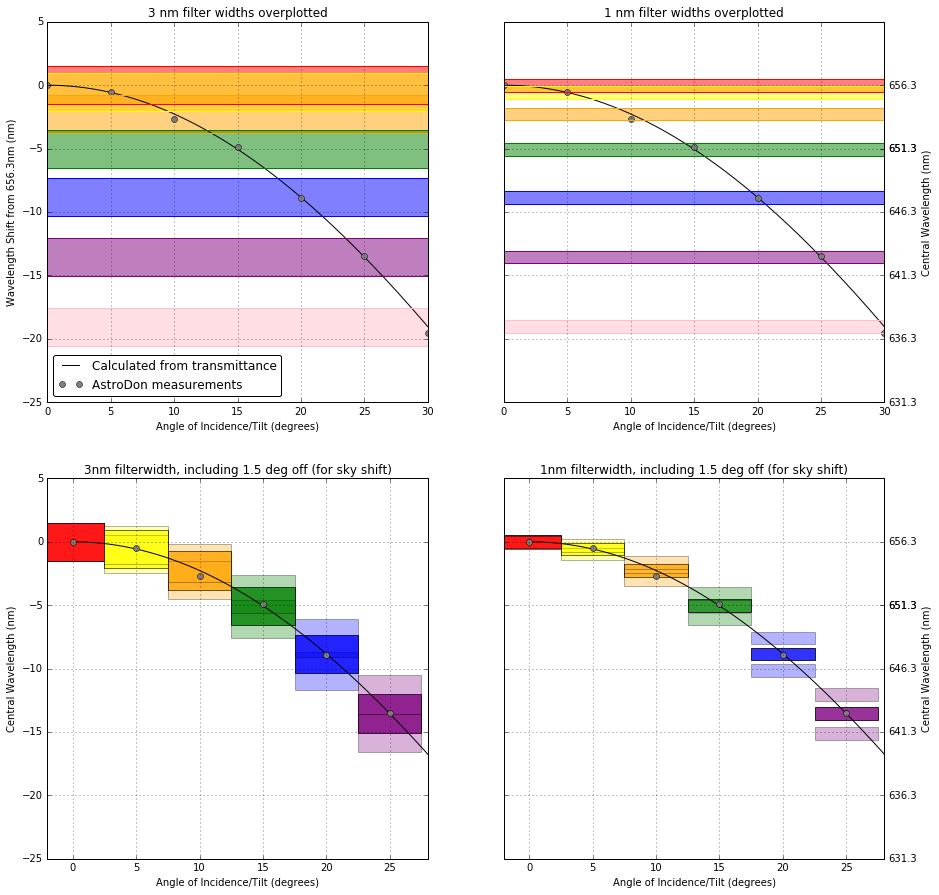

In [222]:
#fig, ax1 = plt.subplots(figsize=[10,10])

fig, ((ax1, ax3), (ax4,ax5)) = plt.subplots(2, 2,figsize=[15,15],sharey=True)

tilt = np.arange(0,30.1,0.1)
eff_index_of_refr = (2.1+1.45)/2.
print(eff_index_of_refr)
eff_index_of_refr_TWEAK = 2.1 # tweaked to fit ("Astro")Don's values
shiftresult = shift(662., tilt, eff_index_of_refr_TWEAK,1)
#print(shiftresult[tilt==1.5])

#print(shiftresult[tilt==0.]-shiftresult[tilt==1.5])
#print(shiftresult[tilt==5.]-shiftresult[tilt==6.5])
#print(shiftresult[tilt==10.]-shiftresult[tilt==11.5])
#print(shiftresult[tilt==15.]-shiftresult[tilt==16.5])

regshift = [shiftresult[tilt==x] for x in AOI]
skyshift_up = [shiftresult[tilt==x+1.5] for x in AOI]
#skyshift_down = [shiftresult[tilt==x-1.5] for x in AOI]
skyshift_down = [shiftresult[np.abs(np.where(tilt==x)[0][0]-15)] for x in AOI[:-1]]
print(len(skyshift_down))
print(len(skyshift_up))

ax1.plot(tilt,shift(662., tilt, eff_index_of_refr_TWEAK,1),'k-',label='Calculated from transmittance')

# needed shifts (as differences)
#plt.plot([0,30],[-21.88,-21.88],'r--',label='Coma') 
#plt.plot([0,30],[-4.38,-4.38],'y--'  ,label='Virgo')  
#plt.plot([0,30],[-1.64,-1.64],'c--'  ,label='Leo I')  
#plt.plot([0,30],[-5,-5],'k--'  ,label='test')  

# Let's also add on the empirical data measured by ("Astro")Don
AOI = np.array([0,5,10,15,20,25,30])
blueshift = np.array([0,0.5,2.7,4.9,8.9,13.5,19.5])
colourarray = ['red','yellow','orange','green','blue','purple','pink']
ax1.plot(AOI,-1*blueshift,'o',color='grey',label='AstroDon measurements')

# calculate polynomial
z = np.polyfit(AOI,blueshift*-1, 2)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(AOI[0], AOI[-1], 50)
y_new = f(x_new)
#ax1.plot(x_new,y_new,label='2-param poly fit to AstroDon')

for blueshiftthis,colour,AOIthis,regshiftthis in zip(blueshift,colourarray,AOI,regshift):
    #print(blueshiftthis,regshiftthis[0])
    low = -1.5+regshiftthis[0]
    high = 1.5+regshiftthis[0]
    ax1.fill_between([0,30], low, high,facecolor =colour,alpha=0.5)
    ax1.plot([0,30],[low,low],colour)
    ax1.plot([0,30],[high,high],colour)

ax1.set_ylabel('Wavelength Shift from 656.3nm (nm)')
ax1.set_xlabel('Angle of Incidence/Tilt (degrees)')
ax1.set_title('3 nm filter widths overplotted')
ax1.set_ylim(-25,5)
ax1.legend(loc=3, fancybox=True)
ax1.grid()

#ax2.plot(AOI,-1*blueshift+656.3,'ro',label='AstroDon measurements')
ax2 = ax3.twinx()
ax2.set_ylabel('Central Wavelength (nm)')
ax2.set_ylim(656.3-25.,656.3+5.)
ax2.set_yticks(656.3+np.array([-25,-20,-15,-10,-5,-0,-5]))

ax3.grid()
ax3.plot(tilt,shift(662., tilt, eff_index_of_refr_TWEAK,1),'k-',label='Calculated from transmittance')
ax3.plot(AOI,-1*blueshift,'o',color='grey',label='AstroDon measurements')
#ax3.plot(x_new,y_new,label='2-param poly fit to AstroDon')
for blueshiftthis,colour,AOIthis,regshiftthis in zip(blueshift,colourarray,AOI,regshift):
    #print(blueshiftthis,regshiftthis[0])
    low = -0.5+regshiftthis[0]
    high = 0.5+regshiftthis[0]
    ax3.fill_between([0,30], low, high,facecolor =colour,alpha=0.5)
    ax3.plot([0,30],[low,low],colour)
    ax3.plot([0,30],[high,high],colour)

ax3.set_title('1 nm filter widths overplotted')
ax3.set_xlabel('Angle of Incidence/Tilt (degrees)')


ax4.grid()
ax4.plot(tilt,shiftresult,'k-',label='Calculated from transmittance')
#ax3.plot(x_new,y_new,label='2-param poly fit to AstroDon')
regshift = [shiftresult[tilt==x] for x in AOI]
skyshift = [shiftresult[tilt==x+1.5] for x in AOI]
for blueshiftthis,colour,AOIthis,regshiftthis,skyshift_upthis,skyshift_downthis in zip(blueshift[:-1],colourarray[:-1],AOI[:-1],regshift[:-1],skyshift_up[:-1],skyshift_down):
    #print(blueshiftthis,regshiftthis[0])
    low = -1.5+regshiftthis[0]
    high = 1.5+regshiftthis[0]
    ax4.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.8)
    
    low = -1.5+skyshift_upthis[0]
    high = 1.5+skyshift_upthis[0]
    ax4.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.3)

    low = -1.5+skyshift_downthis
    high = 1.5+skyshift_downthis
    ax4.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.3)
    
ax4.plot(AOI,-1*blueshift,'o',color='grey',label='AstroDon measurements')
ax4.set_ylabel('Central Wavelength (nm)')


ax4.set_title('3nm filterwidth, including 1.5 deg off (for sky shift)')
ax4.set_xlabel('Angle of Incidence/Tilt (degrees)')
ax4.set_xlim(-2,28)

ax5.grid()

ax5.plot(tilt,shift(662., tilt, eff_index_of_refr_TWEAK,1),'k-',label='Calculated from transmittance')
#ax3.plot(x_new,y_new,label='2-param poly fit to AstroDon')

for blueshiftthis,colour,AOIthis,regshiftthis,skyshift_upthis,skyshift_downthis in zip(blueshift[:-1],colourarray[:-1],AOI[:-1],regshift[:-1],skyshift_up[:-1],skyshift_down):
    #print(blueshiftthis,regshiftthis[0])
    low = -0.5+regshiftthis[0]
    high = 0.5+regshiftthis[0]
    ax5.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.8)
    
    low = -0.5+skyshift_upthis[0]
    high = 0.5+skyshift_upthis[0]
    ax5.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.3)

    low = -0.5+skyshift_downthis
    high = 0.5+skyshift_downthis
    ax5.fill_between([AOIthis-2.5,AOIthis+2.5], low, high,facecolor =colour,alpha=0.3)


ax5.plot(AOI,-1*blueshift,'o',color='grey',label='AstroDon measurements')
    
ax5.set_title('1nm filterwidth, including 1.5 deg off (for sky shift)')
ax5.set_xlabel('Angle of Incidence/Tilt (degrees)')
ax5.set_xlim(-2,28)

ax6 = ax5.twinx()
ax6.set_ylabel('Central Wavelength (nm)')
ax6.set_ylim(656.3-25.,656.3+5.)
ax6.set_yticks(656.3+np.array([-25,-20,-15,-10,-5,-0,-5]))



plt.savefig('FilterTuning.png')



1.775
[-0.05143329]
[ 0.05143329]
[ 0.39216321]
[ 0.72295578]
[ 1.03528424]


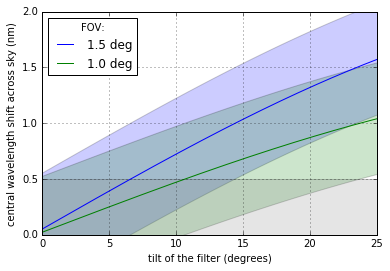

In [149]:
tilt = np.arange(0,30,0.1)
eff_index_of_refr = (2.1+1.45)/2.
print(eff_index_of_refr)
eff_index_of_refr_TWEAK = 2.1 # tweaked to fit ("Astro")Don's values
shiftresult = shift(662., tilt, eff_index_of_refr_TWEAK,1)
print(shiftresult[tilt==1.5])

print(shiftresult[tilt==0.]-shiftresult[tilt==1.5])
print(shiftresult[tilt==5.]-shiftresult[tilt==6.5])
print(shiftresult[tilt==10.]-shiftresult[tilt==11.5])
print(shiftresult[tilt==15.]-shiftresult[tilt==16.5])
plt.plot(tilt,(shiftresult-np.roll(shiftresult,-15)),label='1.5 deg')
plt.plot(tilt,(shiftresult-np.roll(shiftresult,-10)),label='1.0 deg')
plt.fill_between(tilt, (shiftresult-np.roll(shiftresult,-15))-0.5, (shiftresult-np.roll(shiftresult,-15))+0.5,facecolor ='blue',alpha=0.2)
plt.fill_between(tilt, (shiftresult-np.roll(shiftresult,-10))-0.5, (shiftresult-np.roll(shiftresult,-10))+0.5,facecolor ='green',alpha=0.2)
plt.fill_between([0,25],0,0.5,facecolor='grey',alpha=0.2)
plt.legend(title='FOV:',loc=2)
plt.xlim(0,25)
plt.ylim(0,2)
plt.grid()
plt.ylabel('central wavelength shift across sky (nm)')
plt.xlabel('tilt of the filter (degrees)')
plt.savefig('filtertuning_skyshift.pdf')

# The blue and green lines are the shift in central wavelength for an extra 1.5 deg tilt   

At a tilt of 0.0
A shift of 0.05 nm is reached at angle of [ 0.] deg and angle of [ 1.5] deg
A shift of 0.1 nm is reached at angle of [ 0.] deg and angle of [ 2.1] deg
A shift of 0.2 nm is reached at angle of [ 0.] deg and angle of [ 3.] deg
A shift of 0.3 nm is reached at angle of [ 0.] deg and angle of [ 3.6] deg
A shift of 0.4 nm is reached at angle of [ 0.] deg and angle of [ 4.2] deg
A shift of 0.5 nm is reached at angle of [ 0.] deg and angle of [ 4.7] deg
A shift of 0.6 nm is reached at angle of [ 0.] deg and angle of [ 5.1] deg
A shift of 0.7 nm is reached at angle of [ 0.] deg and angle of [ 5.5] deg
A shift of 0.8 nm is reached at angle of [ 0.] deg and angle of [ 5.9] deg
A shift of 0.9 nm is reached at angle of [ 0.] deg and angle of [ 6.3] deg
A shift of 1.0 nm is reached at angle of [ 0.] deg and angle of [ 6.6] deg
At a tilt of 5.0
A shift of 0.05 nm is reached at angle of [ 0.2] deg and angle of [ 0.2] deg
A shift of 0.1 nm is reached at angle of [ 0.5] deg and angle of

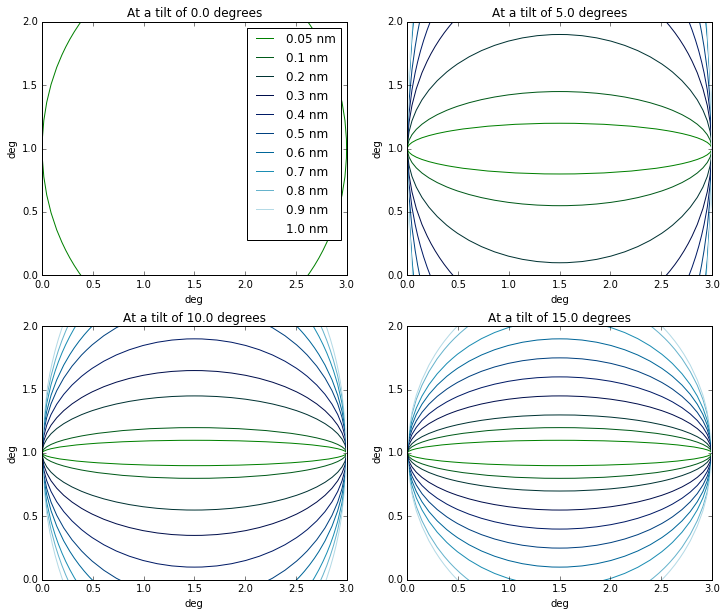

In [285]:
# at tilts of 5, 10, 15 deg from 0, plot contours on FOV where, by that angle, 
# the central wavelength has shifted by 0.05, 0.1, 0.2, ... nm

# Will be elipses, since will have 0deg effect along tilting axis, but tilted effect perpendicular to tilting axis

# shiftresult : contains the central wavelength shifts in steps of 0.1 deg
shiftresult_5 = shiftresult-shiftresult[tilt==5]
shiftresult_10 = shiftresult-shiftresult[tilt==10]
shiftresult_15 = shiftresult-shiftresult[tilt==15]

jet = cm = plt.get_cmap('ocean')
values = range(11)
#colorVal = scalarMap.to_rgba(values[idx])
import matplotlib.colors as colors
import matplotlib.cm as cmx
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = [12,10])
for shiftarray,tile,ax in zip([shiftresult,shiftresult_5,shiftresult_10,shiftresult_15],[0.,5.,10.,15.],[ax1,ax2,ax3,ax4]):
    ax.set_xlim(0,3)
    ax.set_ylim(0,2)
    print('At a tilt of %s'%tile)
    ax.set_ylabel('deg')
    ax.set_xlabel('deg')
    ax.set_title('At a tilt of %s degrees'%tile)
    for shift,idx in zip([0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],range(11)):
        index_b = np.where(np.abs((shiftarray-shift))==np.min(np.abs(shiftarray-shift)))  
        index_t = np.where(np.abs((shiftarray+shift))==np.min(np.abs(shiftarray+shift))) 
        print('A shift of %s nm is reached at angle of %s deg and angle of %s deg'%(shift,tile-tilt[index_b],tilt[index_t]-tile))
        width = (tile-tilt[index_b][0]+tilt[index_t][0]-tile)
        if tile==0:
            ells=Ellipse(xy=[1.5,1.], width=2.*(tilt[index_t][0]-tile), height=2.*(tilt[index_t][0]-tile), angle=90.,fill=False)
            ax.add_artist(ells)
            ells.set_color(scalarMap.to_rgba(idx))
            ax.plot(0,0,color=scalarMap.to_rgba(idx),label='%s nm'%shift)
        else:
            ells=Ellipse(xy=[1.5,1.], width=2.*np.mean([tile-tilt[index_b][0],tilt[index_t][0]-tile]), height=3., angle=90.,fill=False)
            ax.add_artist(ells)
           # ells2 = Ellipse((1.5, 1), 3, 3, 0,fill=False)
           # ax.add_artist(ells2)
           # ells.set_color(( shift/1.,shift/1.,shift/1.))
            ells.set_color(scalarMap.to_rgba(idx))
            ells.set_label('%s nm'%shift)
    if tile==0:
        ax.legend()
            
#At a tilt of 0.0
#A shift of 0.05 nm is reached at angle of [ 0.] deg and angle of [ 1.5] deg
#At a tilt of 5.0
#A shift of 0.05 nm is reached at angle of [ 0.2] deg and angle of [ 0.2] deg
#A shift of 0.1 nm is reached at angle of [ 0.5] deg and angle of [ 0.4] deg
#A shift of 0.2 nm is reached at angle of [ 1.] deg and angle of [ 0.8] deg
#A shift of 0.3 nm is reached at angle of [ 1.6] deg and angle of [ 1.2] deg
#A shift of 0.4 nm is reached at angle of [ 2.3] deg and angle of [ 1.5] deg
#At a tilt of 10.0
#A shift of 0.05 nm is reached at angle of [ 0.1] deg and angle of [ 0.1] deg
#A shift of 0.1 nm is reached at angle of [ 0.2] deg and angle of [ 0.2] deg
#A shift of 0.2 nm is reached at angle of [ 0.5] deg and angle of [ 0.4] deg
#A shift of 0.3 nm is reached at angle of [ 0.7] deg and angle of [ 0.6] deg
#A shift of 0.4 nm is reached at angle of [ 0.9] deg and angle of [ 0.9] deg
#A shift of 0.5 nm is reached at angle of [ 1.2] deg and angle of [ 1.1] deg
#A shift of 0.6 nm is reached at angle of [ 1.4] deg and angle of [ 1.3] deg
#A shift of 0.7 nm is reached at angle of [ 1.7] deg and angle of [ 1.5] deg
#At a tilt of 15.0
#A shift of 0.05 nm is reached at angle of [ 0.1] deg and angle of [ 0.1] deg
#A shift of 0.1 nm is reached at angle of [ 0.2] deg and angle of [ 0.2] deg
#A shift of 0.2 nm is reached at angle of [ 0.3] deg and angle of [ 0.3] deg
#A shift of 0.3 nm is reached at angle of [ 0.5] deg and angle of [ 0.4] deg
#A shift of 0.4 nm is reached at angle of [ 0.6] deg and angle of [ 0.6] deg
#A shift of 0.5 nm is reached at angle of [ 0.8] deg and angle of [ 0.7] deg
#A shift of 0.6 nm is reached at angle of [ 0.9] deg and angle of [ 0.9] deg
#A shift of 0.7 nm is reached at angle of [ 1.1] deg and angle of [ 1.] deg
#A shift of 0.8 nm is reached at angle of [ 1.3] deg and angle of [ 1.2] deg
#A shift of 0.9 nm is reached at angle of [ 1.4] deg and angle of [ 1.3] deg
#A shift of 1.0 nm is reached at angle of [ 1.6] deg and angle of [ 1.5] deg


plt.savefig('filtertuning_skyshiftcontours.pdf')

Note that when the filter is tilted, the wavelength shift is to the *blue* whereas redshift is, clearly, towards the *red*.  Thus when we get a filter, we will need it to be originally centered to the red of the H$\alpha$ line rather than on the H$\alpha$ line, or else we will never be able to adjust it to the correct redshift.

Another note is to consider the broadening of the filter bandwidth as it is tilted for a filter in a convering beam (this effect is calculated in Lofdahl+ 2011).  But actually this might only happen in a converging beam (since the angle of incidence on the filter changes across the pupil plane in a converging beam). In Lofdahl+ 2011, they use the geometry of the converging beam to calculate the broadening by integrating over the pupil field and considering the differing ray angles at each point over the field.

One thing I don't know about is the transmittance of the filter as a function of AOI.

I also had a small moment where I worried about the refraction angle of the light and if it would change it's incidence angle onto the lens by passing through a tilted filter, but then I remembered that the combined effect of the light crossing into the filter and then crossing out of the filter readjusts its direction to the original light path.  So we don't need to worry about that.

Let's say we want 5 nm tunable filter range -- 656.3 to 661.3 nm.

## From AstroDon
They gave us numbers for the blueshift as a function of AOI.

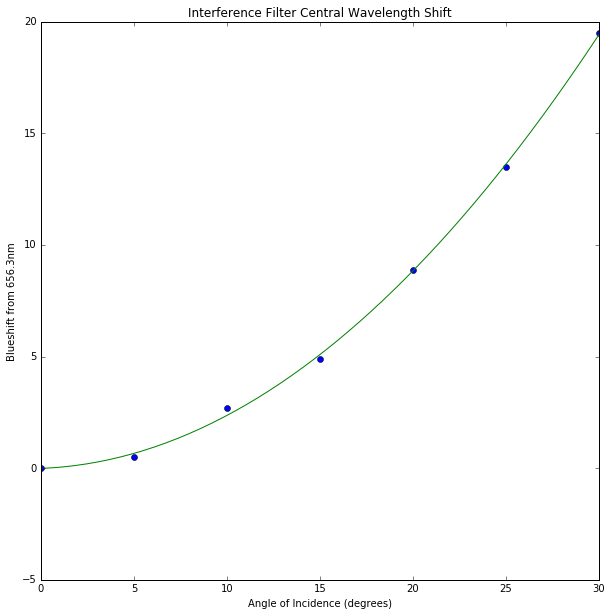

In [9]:
plt.figure(figsize=[10,10])

AOI = [0,5,10,15,20,25,30]
Blueshift_nm = [0,0.5,2.7,4.9,8.9,13.5,19.5]
plt.plot(AOI,Blueshift_nm,'o')

# calculate polynomial
z = np.polyfit(AOI, Blueshift_nm, 2)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(AOI[0], AOI[-1], 50)
y_new = f(x_new)
plt.plot(x_new,y_new)

plt.xlabel('Angle of Incidence (degrees)')
plt.ylabel('Blueshift from 656.3nm')
plt.title('Interference Filter Central Wavelength Shift')
plt.savefig('filtertilter_filtercentralwavelengthshift.pdf')

In [215]:

regshift = [shiftresult[tilt==x] for x in AOI]
skyshift1 = [shiftresult[tilt==x+1.5] for x in AOI]
skyshift2 = [shiftresult[np.abs(np.where(tilt==x)[0][0]-15)] for x in AOI[:-1]]

[np.abs(np.where(tilt==x)[0][0]+15) for x in AOI[1:-1]]
[np.where(tilt==x+1.5) for x in AOI]

[(array([15]),),
 (array([65]),),
 (array([115]),),
 (array([165]),),
 (array([215]),),
 (array([265]),),
 (array([], dtype=int64),)]

In [194]:
regshift

[array([ 0.]),
 array([-0.57038561]),
 array([-2.26711816]),
 array([-5.0470843]),
 array([-8.83897343]),
 array([-13.54414242]),
 array([], dtype=float64)]

In [195]:
skyshift1

[array([-0.05143329]),
 array([-0.96254882]),
 array([-2.99007393]),
 array([-6.08236853]),
 array([-10.15981296]),
 array([-15.11579655]),
 array([], dtype=float64)]

In [196]:
skyshift2

[-17.315395603980392,
 -0.27978971592438029,
 -1.6418461748306754,
 -4.1030600609049088,
 -7.6005071839797438,
 -12.043628770397049]

In [ ]:
np.array(regshift)-np.array(skyshift[:])